In [8]:
!pip install nltk
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

You should consider upgrading via the 'pip install --upgrade pip' command.


[nltk_data] Downloading package wordnet to /Users/zzy824/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zzy824/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
import pandas as pd

review=pd.read_csv('./data/Amazon_Reviews.csv')
review['Label']=review['Label'].map({'__label__2 ':1,'__label__1 ':0})
docs_num = review.shape[0]
print("The dataset has "+str(docs_num)+" reviews.")
print(review.head())

The dataset has 199 reviews.
                                              Review  Label
0   Stuning even for the non-gamer: This sound tr...      1
1   The best soundtrack ever to anything.: I'm re...      1
2   Amazing!: This soundtrack is my favorite musi...      1
3   Excellent Soundtrack: I truly like this sound...      1
4   Remember, Pull Your Jaw Off The Floor After H...      1


In [10]:
# Preprocessing for tokenize, stopwords removal, lemmatization
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

tokenizer=RegexpTokenizer(r'\w+')
lemmatizer=WordNetLemmatizer()

for idx, row in review.iterrows():
    tmp = []
    tokens = tokenizer.tokenize(row['Review'])
    for w in tokens:
        if w.lower() not in stopwords.words('english'):
            tmp.append(lemmatizer.lemmatize(w.lower()))
    review.iloc[idx, 0] = ' '.join(tmp)
review.head(20)

,Review,Label
0,stuning even non gamer sound track beautiful p...,1
1,best soundtrack ever anything reading lot revi...,1
2,amazing soundtrack favorite music time hand in...,1
3,excellent soundtrack truly like soundtrack enj...,1
4,remember pull jaw floor hearing played game kn...,1
5,absolute masterpiece quite sure actually takin...,1
6,buyer beware self published book want know rea...,0
7,glorious story loved whisper wicked saint stor...,1
8,five star book finished reading whisper wicked...,1
9,whisper wicked saint easy read book made want ...,1


In [11]:
DF = {}
for idx, row in review.iterrows():
    for w in row['Review'].split():
        try:
            DF[w].add(idx)
        except:
            DF[w] = {idx}
DF = {k: len(v) for k, v in DF.items()}

for i, item in enumerate(sorted(DF.items(), reverse=True, key=lambda x: x[1])):
    if i<5:
        print(item)
    else:
        break
    

vocab = [k for k, v in DF.items()]
vocab_len = len(vocab)
print("There are "+str(vocab_len)+" words in review's vocabulary")

('one', 62)
('book', 54)
('like', 45)
('get', 45)
('time', 39)
There are 2949 words in review's vocabulary


In [12]:
from collections import Counter
import numpy as np

TFIDF = {}
for idx, row in review.iterrows():
    rw = row['Review'].split()
    cnt = Counter(rw)
    for w in np.unique(rw):
        tf = cnt[w]/len(rw)
        df = DF[w]
        idf = np.log((docs_num+1)/(df+1))
        TFIDF[(idx, w)] = tf*idf

n = 0
for k, v in TFIDF.items():
    if n<5:
        print(k, v)
        n += 1
    else:
        break

(0, '_') 0.09332677950844283
(0, 'anyone') 0.057561492565462814
(0, 'away') 0.07449793816650496
(0, 'back') 0.054780089388707126
(0, 'beautiful') 0.08197509898030969


In [13]:
import matplotlib.pyplot as plt
x_axis = [i for i in range(docs_num)]
y_axis = [v for v in vocab]

score = []
for i in range(docs_num):
    for j, v in enumerate(vocab):
        if (i, v) in TFIDF:
            score.append(TFIDF[(i, v)])
        else:
            score.append(0)

data = np.asarray(score).reshape(docs_num, vocab_len).T

fig, ax = plt.subplots(figsize=(200,600))
im = ax.imshow(data, cmap='plasma_r')
ax.xaxis.set_ticks_position('top')
ax.set_xticks(np.arange(docs_num))
ax.set_yticks(np.arange(vocab_len))
ax.set_xticklabels([i for i in range(docs_num)])
ax.set_yticklabels([v for v in vocab])
# ax.set_title("Word weight matrix",x=0.2,y=1.034,fontsize=16)

plt.show()

# plt.imshow(data, cmap='hot')
# # # plt.savefig('test')


<Figure size 20000x60000 with 1 Axes>

In [20]:
"""
P: like(54) great(38) good(35) love(33) best(20)
N: however(15) disappointed(11) waste(10) poor(10) hard(8)
"""
def gen_vector(idx, review):
    Q = np.zeros(10)
    P = np.zeros(10)
    ten_words = ['like', 'great', 'good', 'love', 'best', 
                 'however', 'disappointed', 'waste', 'poor', 'hard']
    for w in ten_words:
        for k, v in TFIDF.items():
            if k[0]==idx and k[1]==w:
                Q[ten_words.index(w)] = v
        for word in review:
            if word==w:
                P[ten_words.index(w)] += 1
                
    return P, Q

tfidf_vectors = []
count_vectors = []
for idx, row in review.iterrows():
    rw = row['Review'].split()
    P, Q = gen_vector(idx, rw)
    tfidf_vectors.append([Q, row['Label']])
    count_vectors.append(P)

for i in range(10):
    print("count vector for document {} is {}".format(i, count_vectors[i]))
    print("tf-idf vector for document {} is {}".format(i, tfidf_vectors[i]))
    
    


count vector for document 0 is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
tf-idf vector for document 0 is [array([0.        , 0.        , 0.        , 0.        , 0.05008433,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 1]
count vector for document 1 is [0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
tf-idf vector for document 1 is [array([0.        , 0.        , 0.        , 0.        , 0.09799108,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 1]
count vector for document 2 is [1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
tf-idf vector for document 2 is [array([0.02129965, 0.        , 0.        , 0.        , 0.03266369,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 1]
count vector for document 3 is [3. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
tf-idf vector for document 3 is [array([0.05878704, 0.        , 0.        , 0.        , 0.0300506 ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 1]
count vector for document 4 is [0. 0. 1. 0. 1. 0. 0. 0. 0. 0

In [15]:
review_vectors = []
pos = ['like', 'great', 'good', 'love', 'best']
neg = ['however', 'disappointed', 'waste', 'poor', 'hard']
for idx, row in review.iterrows():
    rw = row['Review'].split()
    pos_cnt, neg_cnt = 0, 0
    for w in rw:
        if w in pos:
            pos_cnt += 1
        elif w in neg:
            neg_cnt += 1
    review_vectors.append([float(pos_cnt), float(neg_cnt)])

for i in range(docs_num):
    print(str(i)+"th document vector: ", review_vectors[i])
review_vectors = np.asarray(review_vectors)


0th document vector:  [1.0, 0.0]
1th document vector:  [2.0, 0.0]
2th document vector:  [2.0, 0.0]
3th document vector:  [4.0, 0.0]
4th document vector:  [2.0, 0.0]
5th document vector:  [2.0, 0.0]
6th document vector:  [0.0, 0.0]
7th document vector:  [0.0, 0.0]
8th document vector:  [1.0, 0.0]
9th document vector:  [0.0, 0.0]
10th document vector:  [0.0, 3.0]
11th document vector:  [3.0, 0.0]
12th document vector:  [1.0, 0.0]
13th document vector:  [0.0, 1.0]
14th document vector:  [1.0, 3.0]
15th document vector:  [0.0, 1.0]
16th document vector:  [1.0, 0.0]
17th document vector:  [1.0, 0.0]
18th document vector:  [1.0, 1.0]
19th document vector:  [0.0, 0.0]
20th document vector:  [2.0, 0.0]
21th document vector:  [3.0, 1.0]
22th document vector:  [2.0, 1.0]
23th document vector:  [1.0, 0.0]
24th document vector:  [1.0, 0.0]
25th document vector:  [0.0, 0.0]
26th document vector:  [0.0, 0.0]
27th document vector:  [0.0, 2.0]
28th document vector:  [0.0, 0.0]
29th document vector:  [

In [16]:
from scipy.spatial.distance import cdist
class K_means():
    def __init__(self, X, k, c):
        self.X = X
        self.k = k
        self.c = c
        self.i = 0
    
    def __call__(self, max_iter=10000):
        diag = np.eye(self.k)
        self.c = self.X[np.random.choice(len(self.X), self.k, replace=False)]
        for i in range(max_iter):
            self.i = i
            prev_c = np.copy(self.c)
            dist = cdist(self.X, self.c)
            cluster_idx = np.argmin(dist, axis=1)
            cluster_idx = diag[cluster_idx]
            self.c = np.sum(self.X[:, None, :] * cluster_idx[:, :, None], axis=0) / np.sum(cluster_idx, axis=0)[:, None]
            if np.allclose(prev_c, self.c, atol=1e-3):
                break

def plotAns(data, center=None):
    plt.plot(data[:, 0], data[:, 1], 'x')
    plt.plot(center[:, 0], center[:, 1], 'o')
    plt.axis('equal')
    plt.show()   


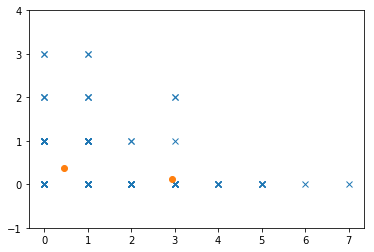

1


In [17]:
k1 = K_means(X=review_vectors, k=2, c=None)
k1.__call__()
plotAns(review_vectors, k1.c)
print(k1.i)

/Users/zzy824/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


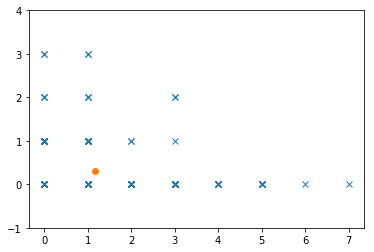

9999


In [18]:
k2 = K_means(X=review_vectors, k=3, c=None)
k2.__call__()
plotAns(review_vectors, k2.c)
print(k2.i)

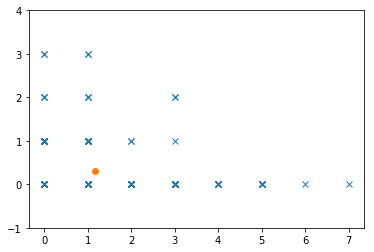

9999


In [19]:
np.seterr(divide='ignore', invalid='ignore')
k3 = K_means(X=review_vectors, k=4, c=None)
k3.__call__()
plotAns(review_vectors, k3.c)
print(k3.i)